In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import os

import matplotlib.pyplot as plt

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

In [2]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
#plt.style.use('default')
plt.style.use('dark_background')

import seaborn as sns
_font_size = 7.5
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

## cleanup downloaded data

downloaded from:
https://portal.brain-map.org/atlases-and-data/rnaseq/human-m1-10x


In [3]:
# Only run this for the first time!
overwrite = False
seq_ref_folder = r'\\10.245.74.158\Chromatin_NAS_8\MERFISH\human\10xM1'
# adata file
seq_raw_filename = os.path.join(seq_ref_folder, 'hM1_10x_raw.h5ad')
seq_processed_filename = os.path.join(seq_ref_folder, 'hM1_10x_processed.h5ad')
sel_seq_processed_filename = os.path.join(seq_ref_folder, 'sel_hM1_10x_processed.h5ad')

In [4]:
figure_folder = os.path.join(seq_ref_folder, 'Figures')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")

sc.settings.figdir = figure_folder

Use figure_folder: \\10.245.74.158\Chromatin_NAS_8\MERFISH\human\10xM1\Figures


In [5]:
# load metadata
metadata_df = pd.read_csv(os.path.join(seq_ref_folder, 'metadata.csv'), low_memory=False)#.set_index('sample_name')


In [6]:
# load counts
count_df = pd.read_csv(os.path.join(seq_ref_folder, 'matrix.csv'), low_memory=False).set_index('sample_name')


In [13]:
# assemble anndata
if not os.path.exists(seq_raw_filename):
    adata = sc.AnnData(count_df, dtype=np.float32)
    adata.obs = adata.obs.merge(metadata_df, left_index=True, right_on='sample_name').set_index('sample_name')
    adata.write(seq_raw_filename)
else:
    # load from here:
    print('loading from file:')
    adata = sc.read_h5ad(seq_raw_filename)

In [30]:
len(adata)

76533

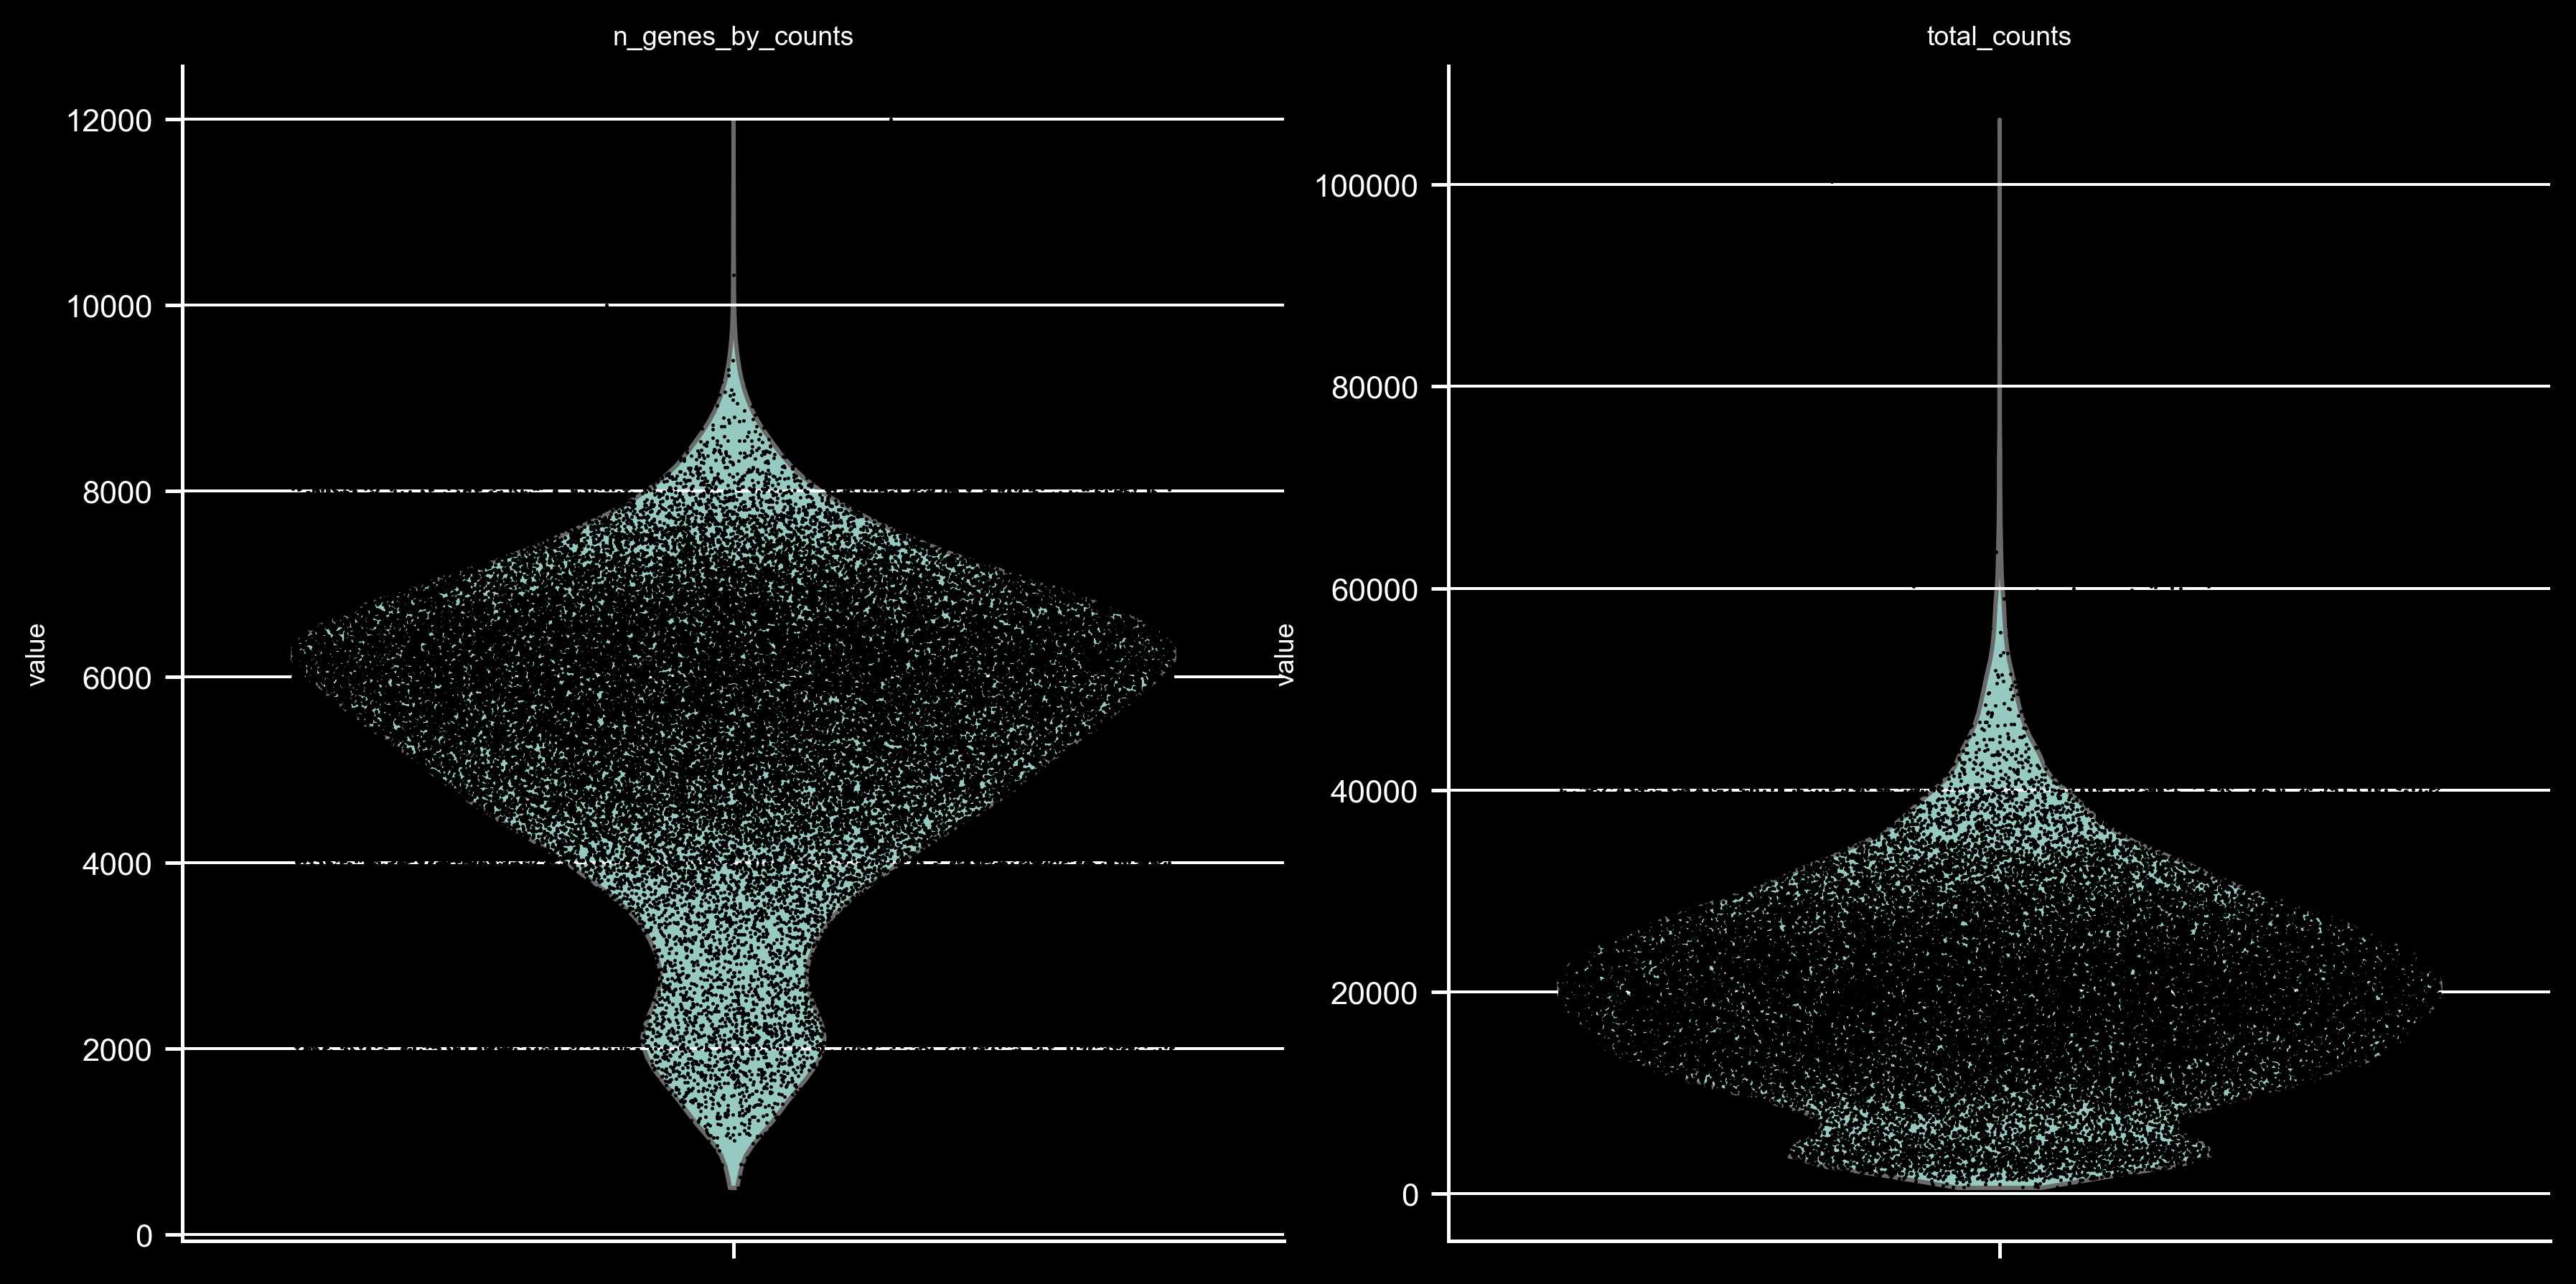

In [14]:
# A violin plot of some of the computed quality measures:
# - the number of genes expressed in the count matrix
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
# - the total counts per cell
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True, )#save='_counts_after_filter.png')

In [ ]:
# normalize
sc.pp.normalize_total(adata, target_sum=_total_median) 
# Logarithmize the data
sc.pp.log1p(adata)
# Regress out total counts
sc.pp.regress_out(adata, 'total_counts')
# Convert gene expressions to Z-scores
sc.pp.scale(adata, max_value=10)
# Principal component analysis
sc.tl.pca(adata, svd_solver='arpack', n_comps=100)
# Plot the PCA results
sc.pl.pca(adata, save='_all_cells.png')

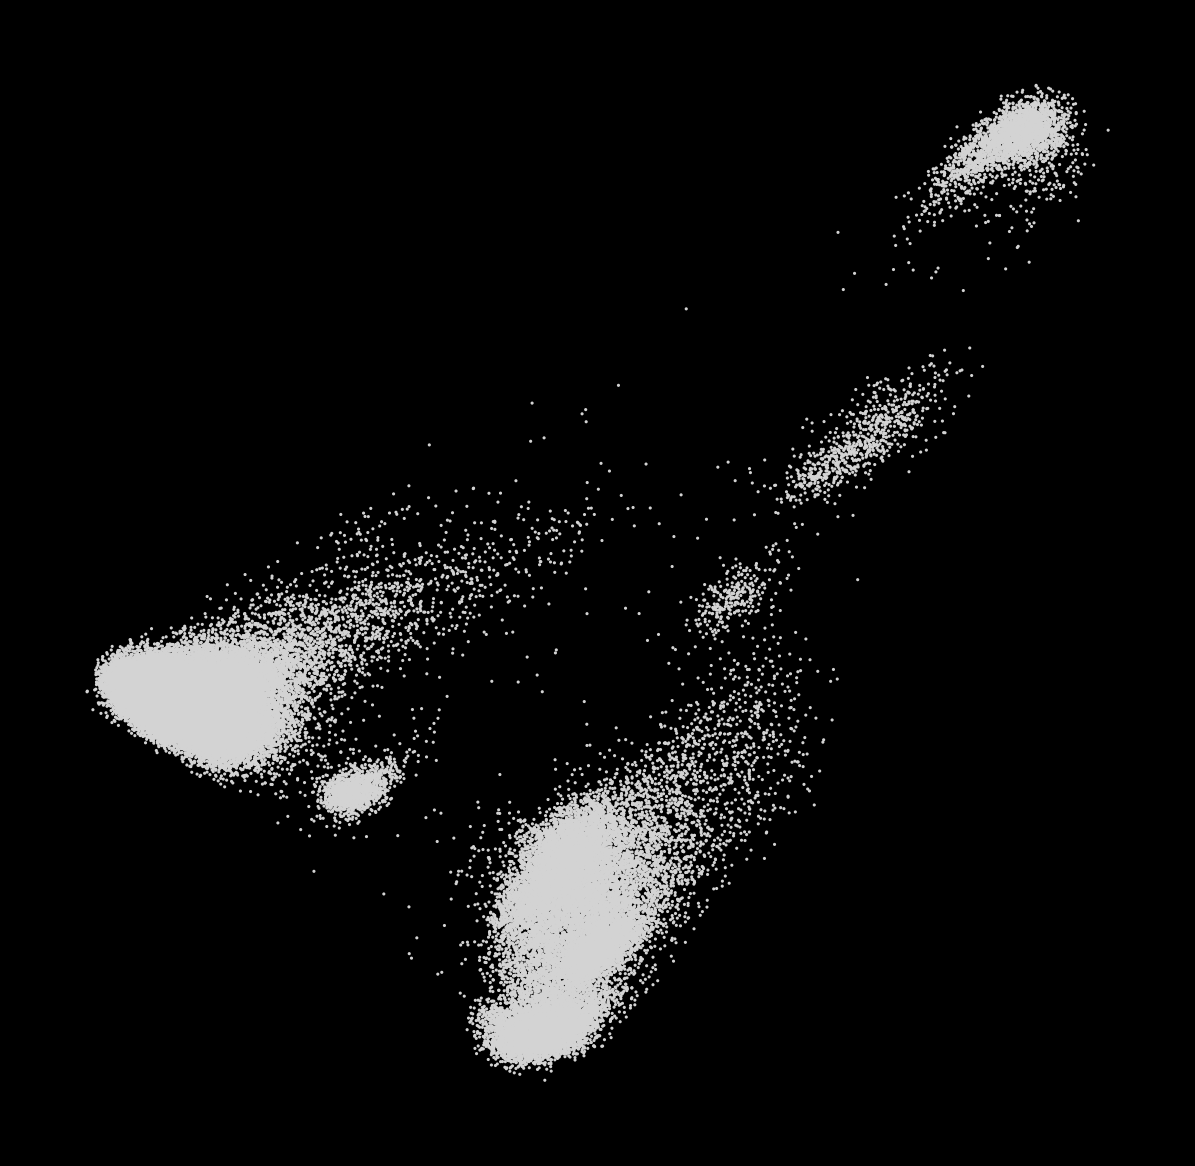

In [16]:
# Principal component analysis
sc.tl.pca(adata, svd_solver='arpack', n_comps=100)
# Plot the PCA results
sc.pl.pca(adata, save='_all_cells.png')

In [20]:
%%time
# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=30)
# Clustering
sc.tl.leiden(adata, resolution=0.5)

Wall time: 8.27 s


In [21]:
%%time
# Embed with UMAP
sc.tl.umap(adata)

Wall time: 47.9 s


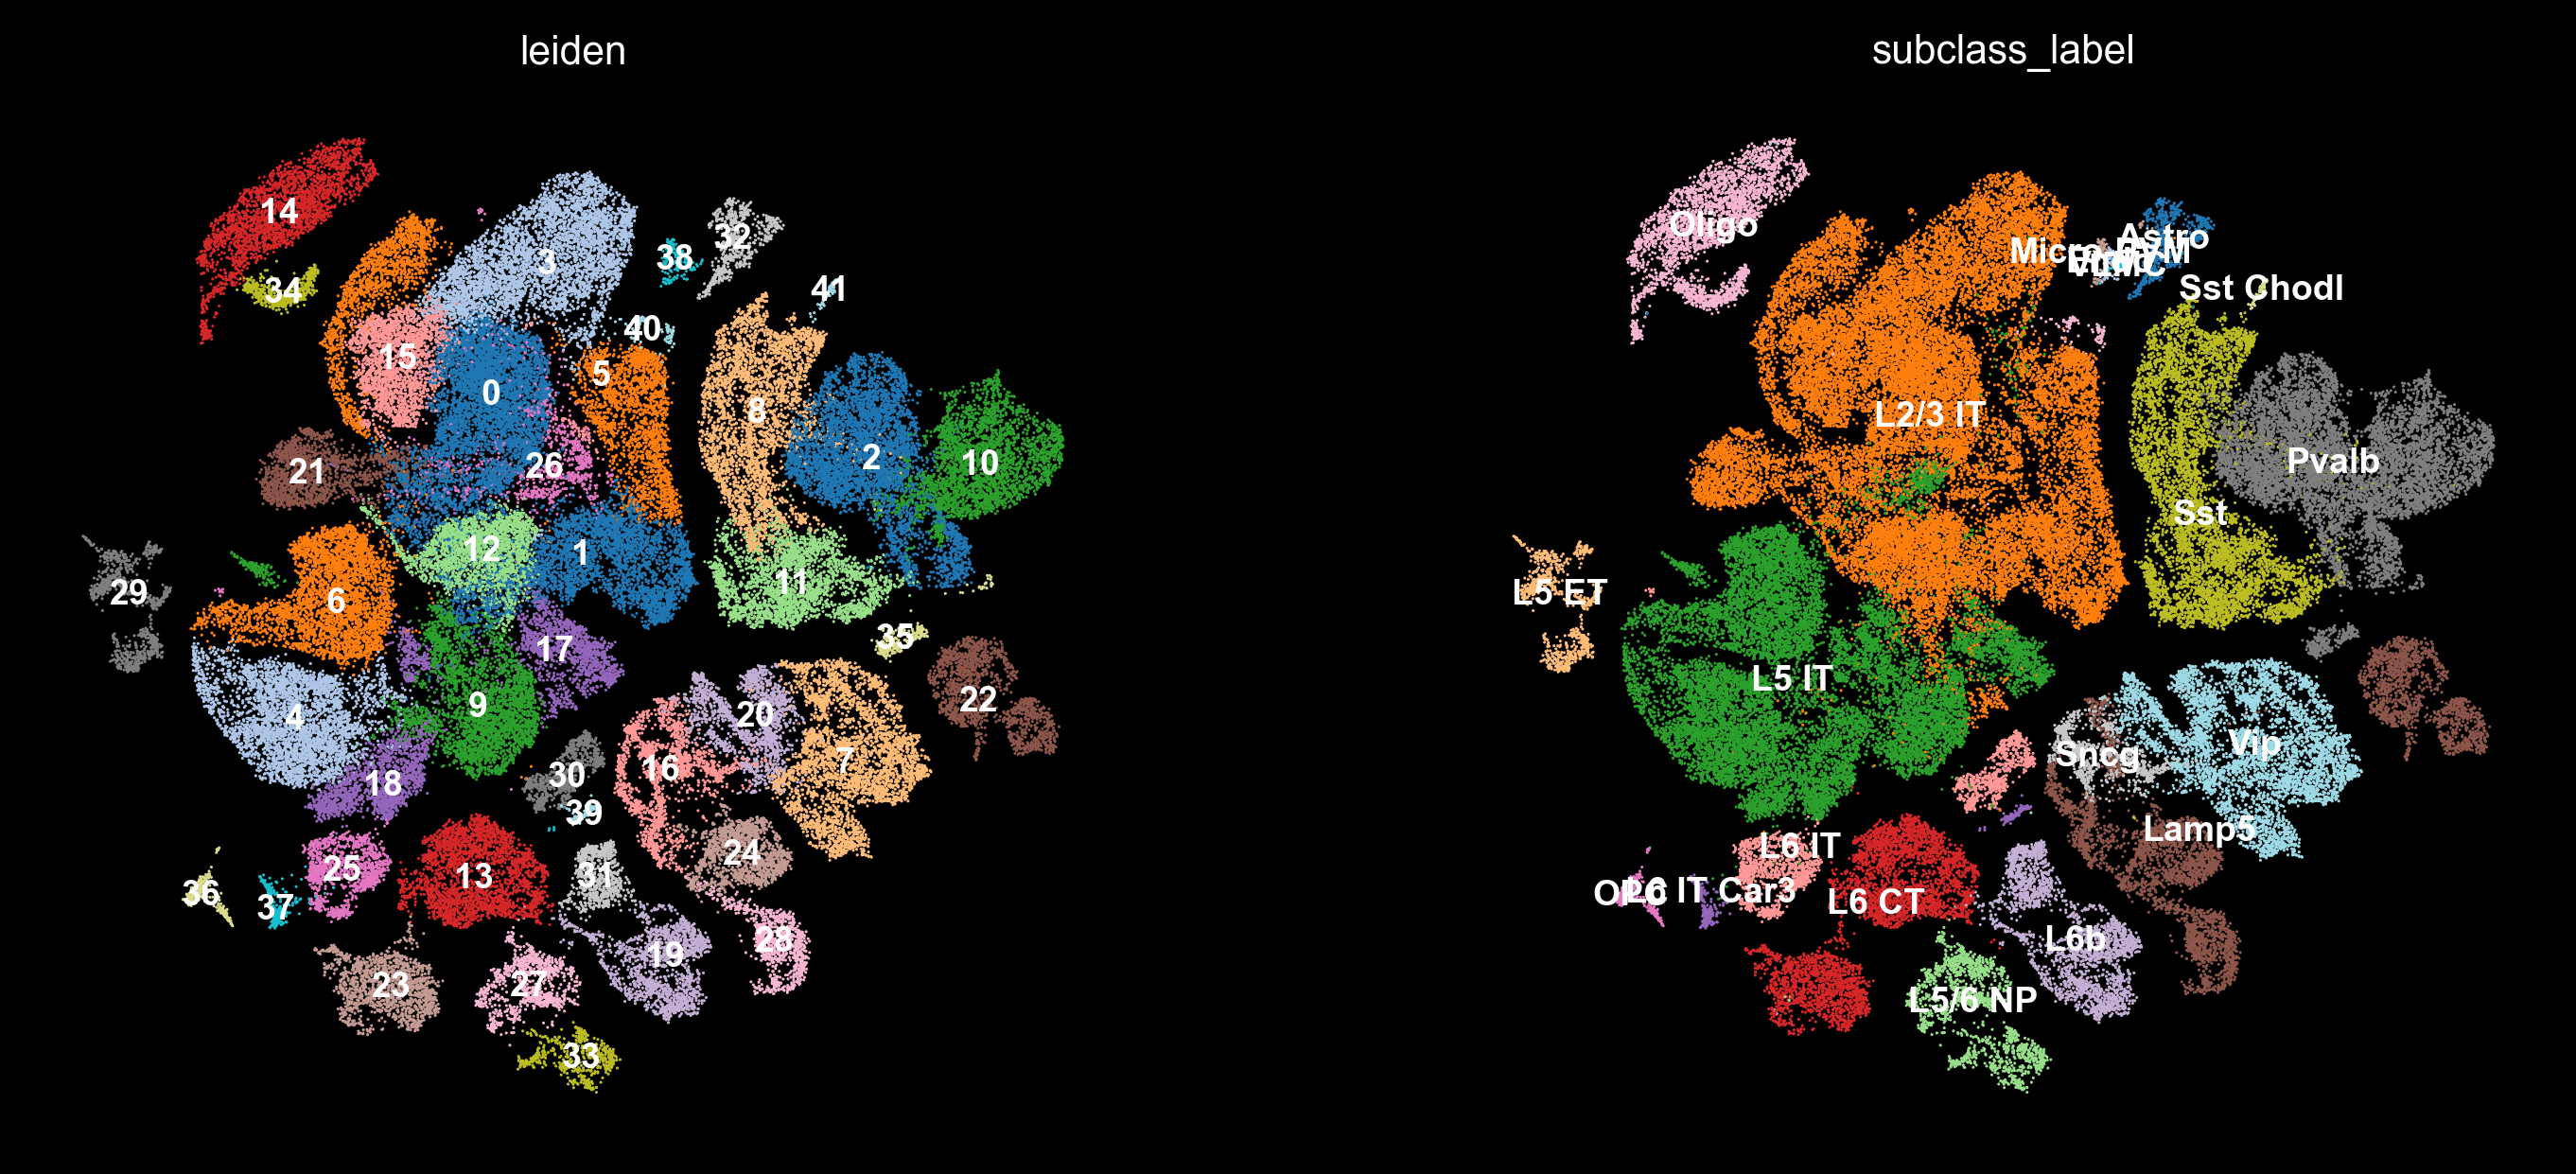

Wall time: 3.74 s


In [22]:
%%time
# Plot the UMAP
sc.pl.umap(adata, color=['leiden', 'subclass_label'], 
           legend_loc='on data',
           palette='tab20',
           save='_allgene_cluster.png',
           )

In [ ]:
adata.write(seq_processed_filename)

# sel genes

In [34]:
merlin_output_master_folder = r'\\10.245.74.158\Chromatin_NAS_8\MERFISH\human'
save_filename = os.path.join(merlin_output_master_folder, 'hM1_hM1_summary', 'filtered_cluster_data.h5ad')

merfish_adata = sc.read(save_filename)

In [93]:
# match genes
matched_genes = []
matched_gene_idx = []
for _gene in merfish_adata.var.index:
    if _gene in count_df.columns[1:]:
        matched_genes.append(_gene)
        matched_gene_idx.append(np.where(adata.var.index==_gene)[0][0])
    

In [98]:
sel_count_df

CD52  PTPRU  MARCKSL1  RSPO1  POU3F1  \
sample_name                                                                 
AAACCCAAGGATTTCC-LKTX_190129_01_A01     0      2         0      0       0   
AAACCCAAGTATGGCG-LKTX_190129_01_A01     0      0         1      0       0   
AAACCCACAAAGTGTA-LKTX_190129_01_A01     0      0         0      0       0   
AAACCCACACTACTTT-LKTX_190129_01_A01     0      0         0      0       0   
AAACCCACAGTGAGCA-LKTX_190129_01_A01     0      0         2      0       0   
...                                   ...    ...       ...    ...     ...   
TTTGTTGAGATGGCGT-LKTX_190130_01_H01     0      0         2      0       0   
TTTGTTGCACAGCCAC-LKTX_190130_01_H01     0      0         0      0       0   
TTTGTTGCAGAGACTG-LKTX_190130_01_H01     0      0         0      0       0   
TTTGTTGCATAATGAG-LKTX_190130_01_H01     0      0         1      0       0   
TTTGTTGTCTACTCAT-LKTX_190130_01_H01     0      0         0      0       0   

                                     RAB3B  ROR1  PTGER3  SLC44A5  ST6GALNAC5  \
sample_name                                                                     
AAACCCAAGGATTTCC-LKTX_190129_01_A01      2     0       0       18           9   
AAACCCAAGTATGGCG-LKTX_190129_01_A01      1     0       0        2          12   
AAACCCACAAAGTGTA-LKTX_190129_01_A01      0     0       0        9           3   
AAACCCACACTACTTT-LKTX_190129_01_A01      0     0       0        0           2   
AAACCCACAGTGAGCA-LKTX_190129_01_A01      1     0       0        0           0   
...                                    ...   ...     ...      ...         ...   
TTTGTTGAGATGGCGT-LKTX_190130_01_H01      0     0       0        0           0   
TTTGTTGCACAGCCAC-LKTX_190130_01_H01      0     0       0       19          27   
TTTGTTGCAGAGACTG-LKTX_190130_01_H01      0     0       0        1           1   
TTTGTTGCATAATGAG-LKTX_190130_01_H01      0     4       0        0           0   
TTTGTTGTCTACTCAT-LKTX_190130_01_H01      0     0       0       33          21   

                                     ...  SYNE2  IFI27  CDH11  ZFHX3  VAT1L  \
sample_name                          ...                                      
AAACCCAAGGATTTCC-LKTX_190129_01_A01  ...      0      0      0      0      0   
AAACCCAAGTATGGCG-LKTX_190129_01_A01  ...      0      0     10      0      1   
AAACCCACAAAGTGTA-LKTX_190129_01_A01  ...      0      0      1      0      0   
AAACCCACACTACTTT-LKTX_190129_01_A01  ...      0      0      0      0      0   
AAACCCACAGTGAGCA-LKTX_190129_01_A01  ...      0      0      0      0      0   
...                                  ...    ...    ...    ...    ...    ...   
TTTGTTGAGATGGCGT-LKTX_190130_01_H01  ...      0      0      0      0      0   
TTTGTTGCACAGCCAC-LKTX_190130_01_H01  ...      1      0      0      0      1   
TTTGTTGCAGAGACTG-LKTX_190130_01_H01  ...      0      0      0      0      0   
TTTGTTGCATAATGAG-LKTX_190130_01_H01  ...      0      0      0      0      0   
TTTGTTGTCTACTCAT-LKTX_190130_01_H01  ...      2      0      5      0      0   

                                     EPN2  NPTX1  ZNF536  KIAA1755  PCDH11X  
sample_name                                                                  
AAACCCAAGGATTTCC-LKTX_190129_01_A01     1      1       4         0        7  
AAACCCAAGTATGGCG-LKTX_190129_01_A01     0      1       0         0        7  
AAACCCACAAAGTGTA-LKTX_190129_01_A01     1      3       0         0       11  
AAACCCACACTACTTT-LKTX_190129_01_A01     0      1       0         0        0  
AAACCCACAGTGAGCA-LKTX_190129_01_A01     2      0       3         8        0  
...                                   ...    ...     ...       ...      ...  
TTTGTTGAGATGGCGT-LKTX_190130_01_H01     1      0       2         1        0  
TTTGTTGCACAGCCAC-LKTX_190130_01_H01     3      1       0         0        4  
TTTGTTGCAGAGACTG-LKTX_190130_01_H01     0      0       0         0        0  
TTTGTTGCATAATGAG-LKTX_190130_01_H01     1      0       1         0        0  
TTTGTTGTCTACTCAT-

In [99]:
# version 2
sel_count_df = count_df[matched_genes]

sel_adata = sc.AnnData(sel_count_df, dtype=np.float32, obs=metadata_df.set_index('sample_name'))

sc.pp.calculate_qc_metrics(sel_adata, percent_top=None, log1p=False, inplace=True)

sel_seq_raw_filename = os.path.join(seq_ref_folder, 'sel_hM1_10x_raw.h5ad')
print(f"Saving to file: {sel_seq_raw_filename}")

sel_adata.write(sel_seq_raw_filename)

Saving to file: \\10.245.74.158\Chromatin_NAS_8\MERFISH\human\10xM1\sel_hM1_10x_raw.h5ad


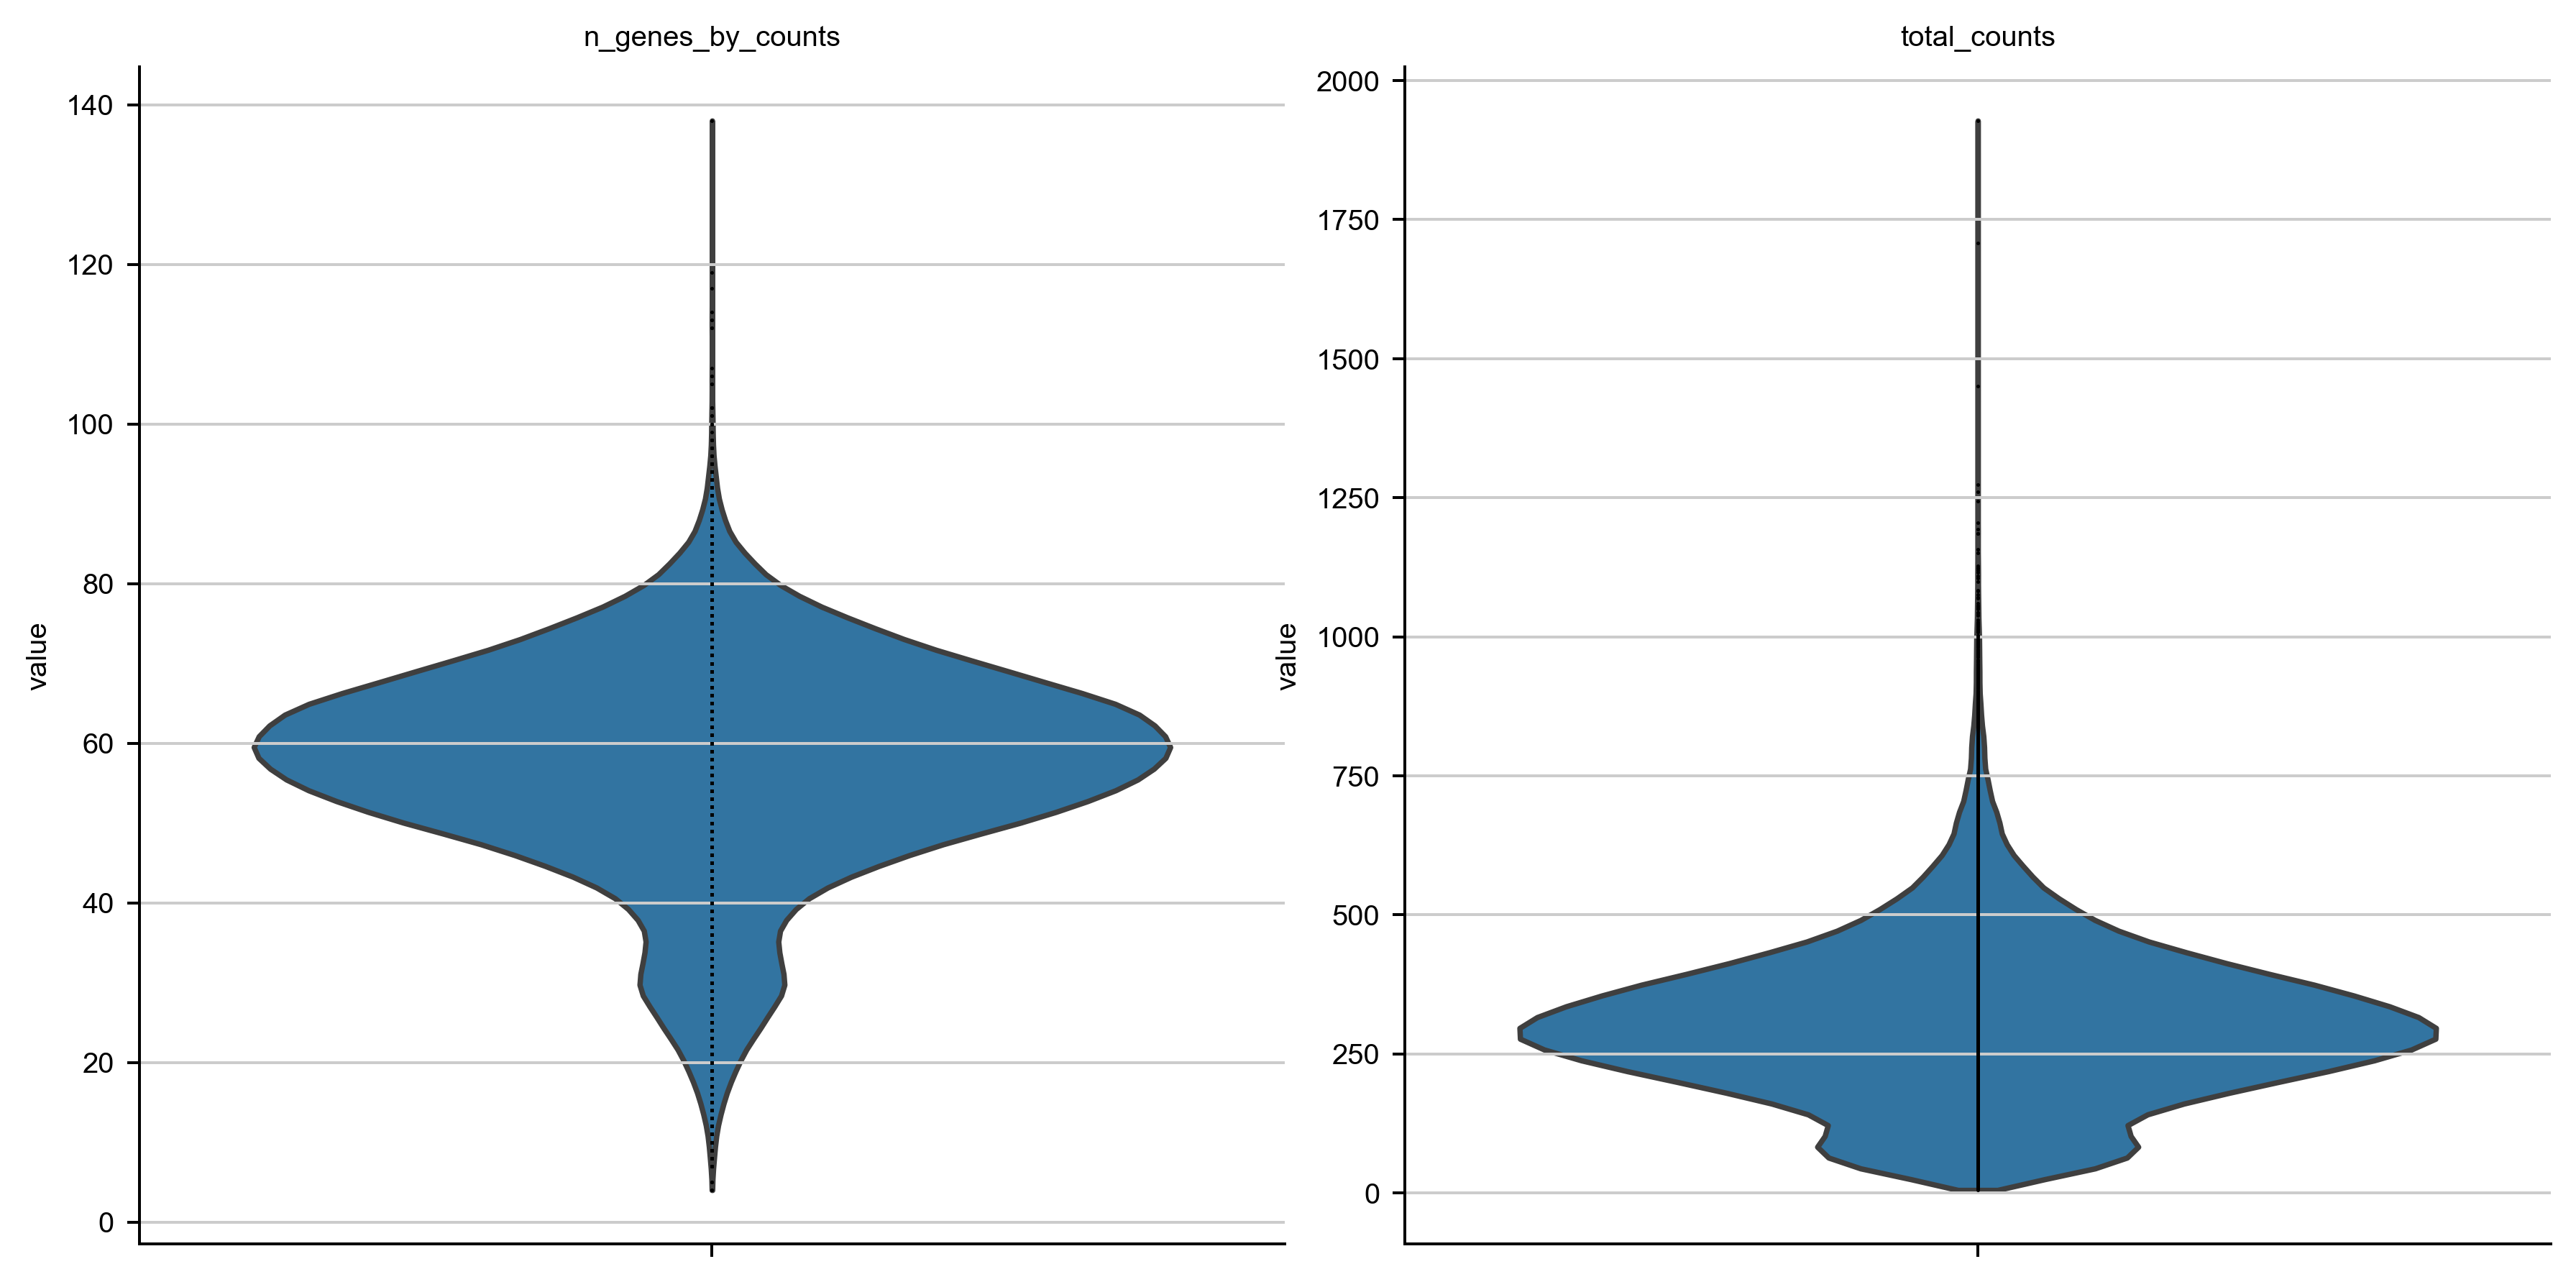

In [96]:
# A violin plot of some of the computed quality measures:
# - the number of genes expressed in the count matrix
# - the total counts per cell
sc.pl.violin(sel_adata, ['n_genes_by_counts', 'total_counts'],
             jitter=False, multi_panel=True, outlier=False, save='_sel_genes_counts_after_filter.png')

In [97]:
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(sel_adata, target_sum=1e2)
# Logarithmize the data
sc.pp.log1p(sel_adata)

sel_seq_processed_filename = os.path.join(seq_ref_folder, 'sel_hM1_10x_processed.h5ad')
print(f"Saving to file: {sel_seq_processed_filename}")
sel_adata.write(sel_seq_processed_filename)

Saving to file: \\10.245.74.158\Chromatin_NAS_8\MERFISH\human\10xM1\sel_hM1_10x_processed.h5ad


In [24]:
sel_seq_processed_filename = os.path.join(seq_ref_folder, 'sel_hM1_10x_processed.h5ad')

sel_adata = sc.read_h5ad(sel_seq_processed_filename)

In [25]:
sel_adata

AnnData object with n_obs × n_vars = 76533 × 260
    obs: 'exp_component_name', 'cluster_label', 'cluster_color', 'cluster_order', 'class_label', 'class_color', 'class_order', 'subclass_label', 'subclass_color', 'subclass_order', 'donor_sex_label', 'donor_sex_color', 'donor_sex_order', 'region_label', 'region_color', 'region_order', 'cortical_layer_label', 'cortical_layer_color', 'cortical_layer_order', 'cell_type_accession_label', 'cell_type_accession_color', 'cell_type_accession_order', 'cell_type_alias_label', 'cell_type_alias_color', 'cell_type_alias_order', 'cell_type_alt_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_order', 'cell_type_designation_label', 'cell_type_designation_color', 'cell_type_designation_order', 'external_donor_name_label', 'external_donor_name_color', 'external_donor_name_order', 'specimen_type', 'full_genotype_label', 'outlier_call', 'outlier_type', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropou

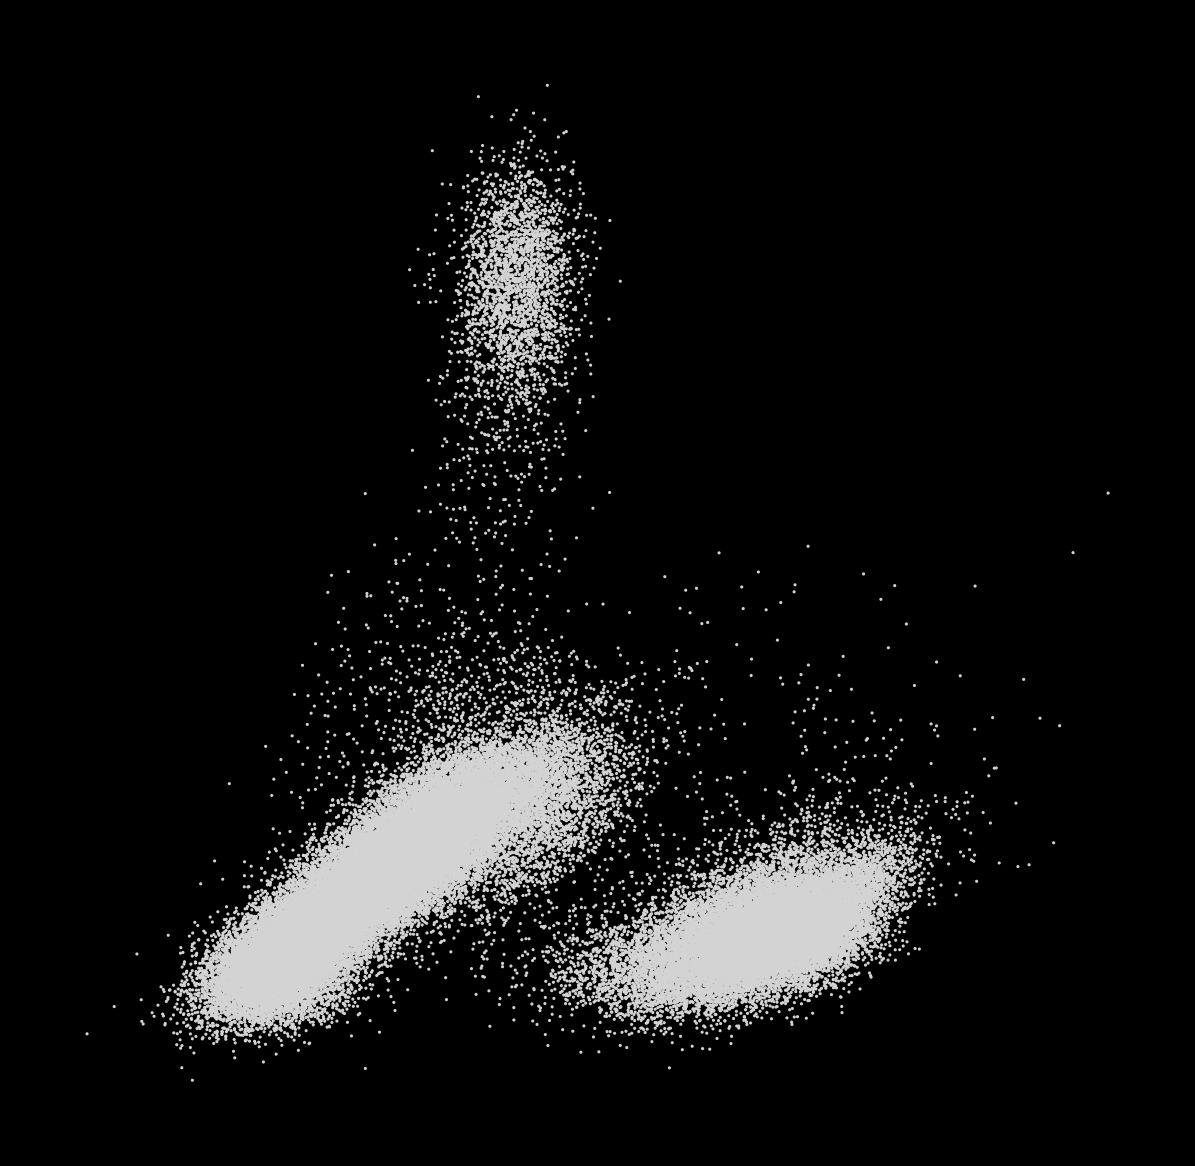

In [26]:
# Regress out total counts
sc.pp.regress_out(sel_adata, 'total_counts')
# Convert gene expressions to Z-scores
sc.pp.scale(sel_adata, max_value=10)
# Principal component analysis
sc.tl.pca(sel_adata, svd_solver='arpack')
# Plot the PCA results
sc.pl.pca(sel_adata, )

In [27]:
%%time
# Computing the neighborhood graph
sc.pp.neighbors(sel_adata, n_neighbors=8, n_pcs=30)
# Clustering
sc.tl.leiden(sel_adata, resolution=0.8)
# Embed with UMAP
sc.tl.umap(sel_adata)

Wall time: 1min 11s


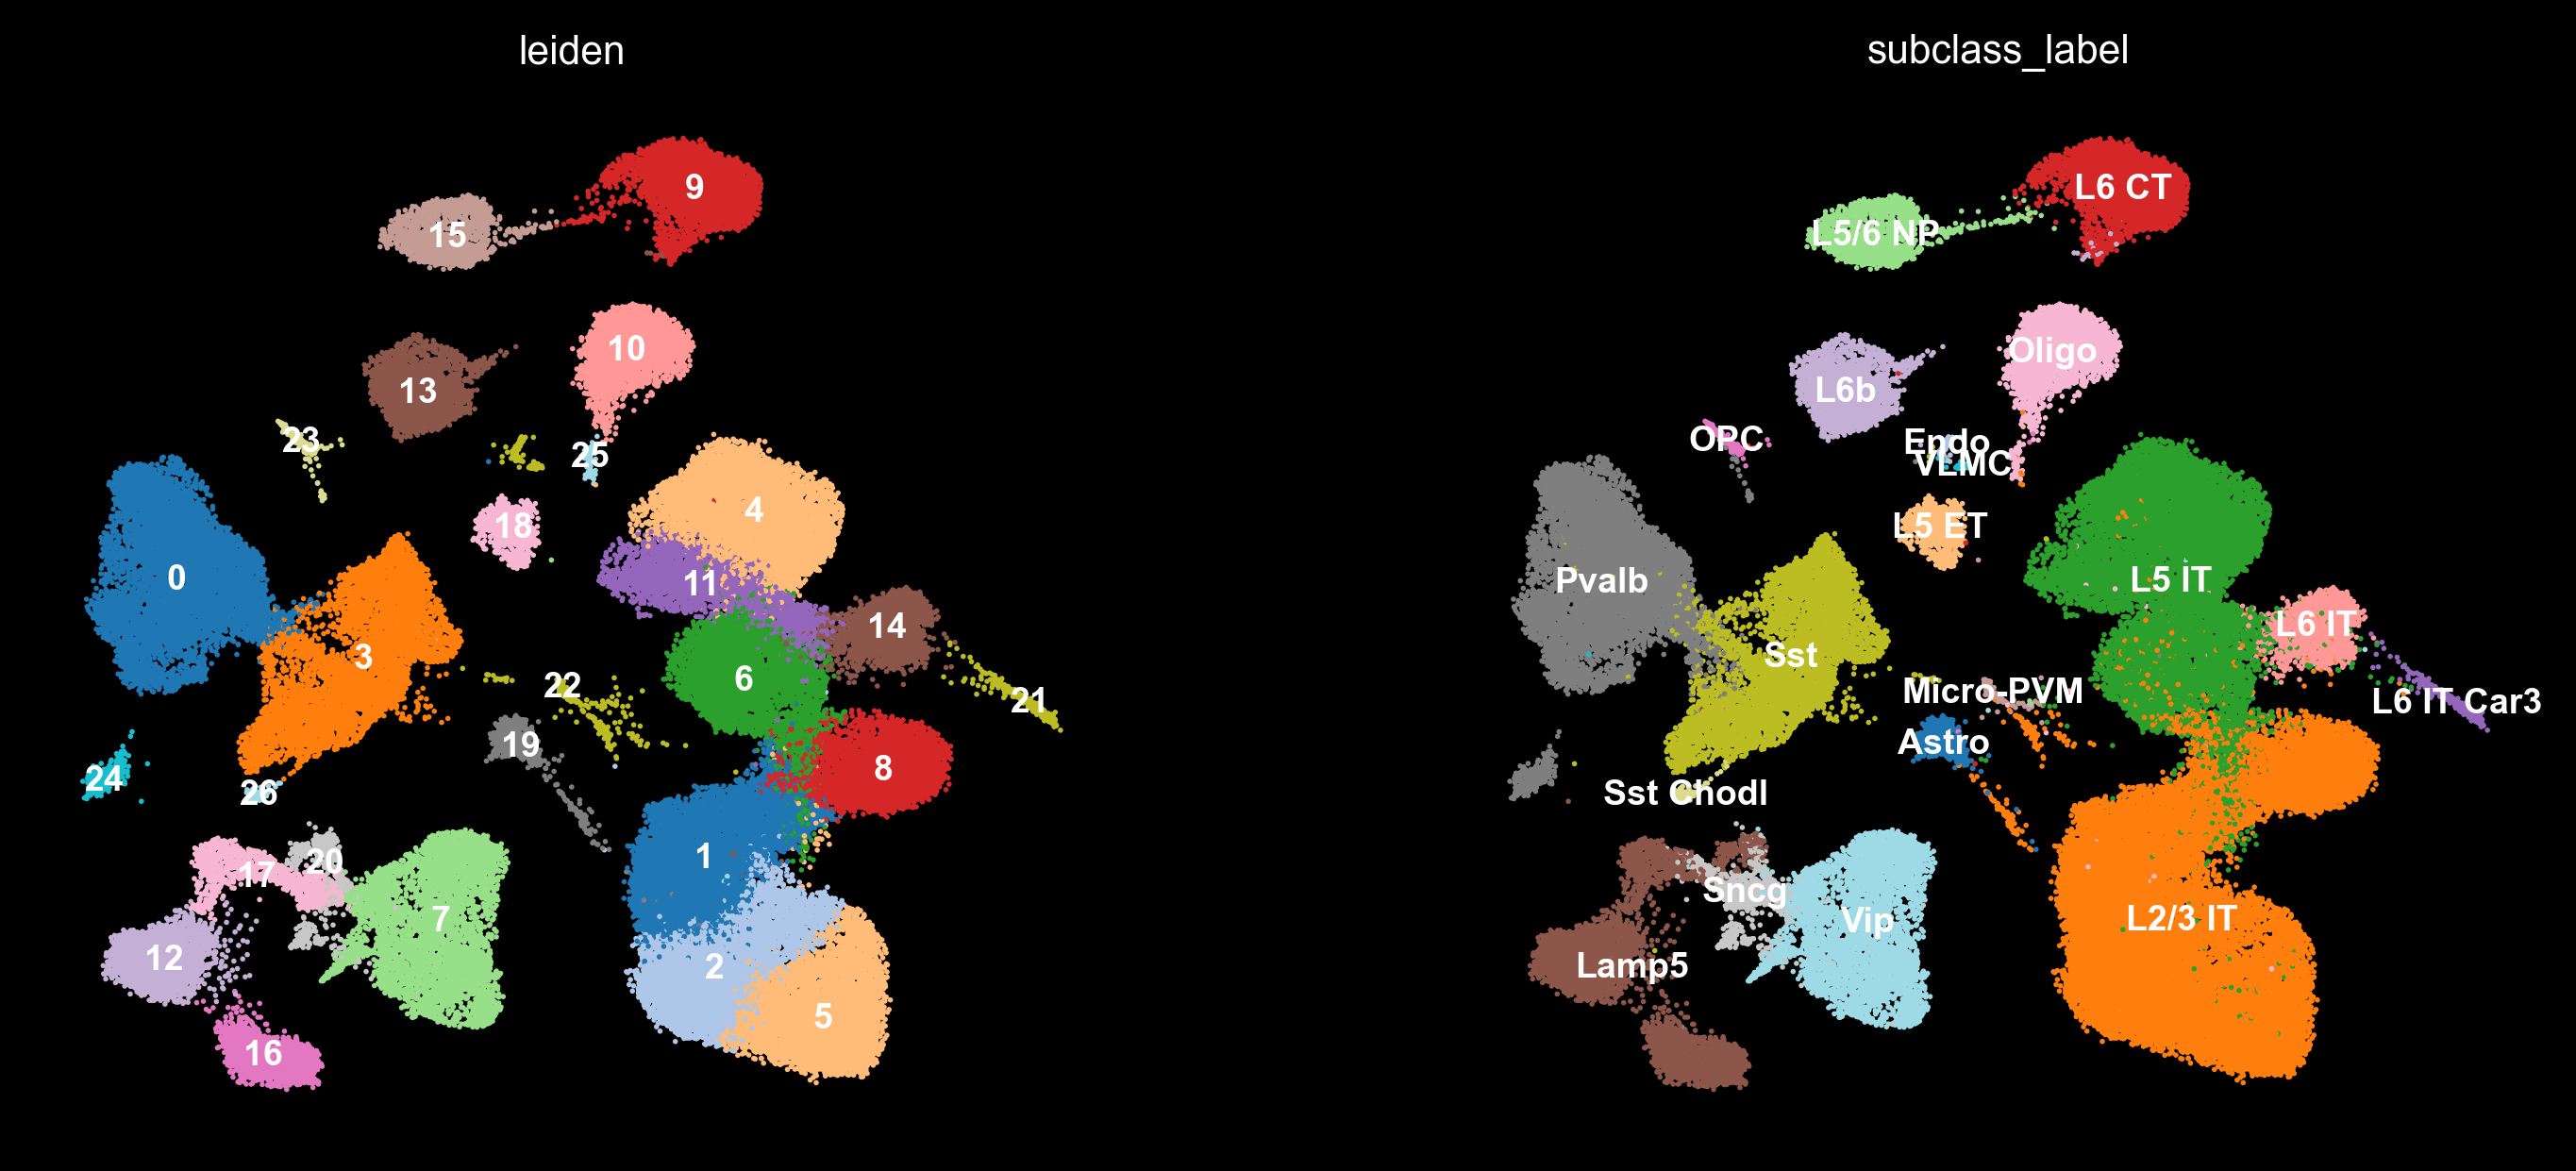

Wall time: 3.5 s


In [29]:
%%time
# Plot the UMAP
sc.pl.umap(sel_adata, color=['leiden', 'subclass_label'], 
           legend_loc='on data',
           palette='tab20',
           save='_selectedgene_initial_cluster.png',
           s=5,
           )